In [51]:
from sklearn.datasets import fetch_openml
from rfgap import RFGAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import dataprep
from phate import PHATE

from sklearn.model_selection import train_test_split

In [52]:
# data = fetch_openml(name='tic-tac-toe', version=1, as_frame=True)

# x = data['data']
# y = data['target']
# y = pd.Categorical(y).codes
# x = dataprep(x, label_col_idx = None, scale = None)

In [53]:
# data   = pd.read_csv('../datasets/2_class_normal.csv', sep = ',')
data   = pd.read_csv('../datasets/titanic.csv', sep = ',')
x, y   = dataprep(data)
n, d   = x.shape
n_classes = len(y.unique())

In [54]:
x_train, x_test, y_train, y_test, inds_train, inds_test = train_test_split(x, y, np.arange(n), test_size=0.1, random_state = 42)

In [55]:
rf = RFGAP(oob_score = True, non_zero_diagonal = False, random_state = 42) #non_zero_diagonal must be false
rf.fit(x, y)
prox = rf.get_proximities()

In [56]:
rf2 = RFGAP(oob_score = True, non_zero_diagonal = True, random_state = 42) #non_zero_diagonal must be false for trust
rf2.fit(x, y)
prox2 = rf2.get_proximities()

In [57]:
rf3 = RFGAP(oob_score = True, non_zero_diagonal = False, random_state = 42)
rf3.fit(x_train, y_train)
prox3 = rf3.get_proximities()

In [58]:
trust_scores = rf.get_trust_scores()
trust_scores_test = rf3.get_test_trust(x_test)

Currently minus not taking oob_correct into account


<Axes: ylabel='Density'>

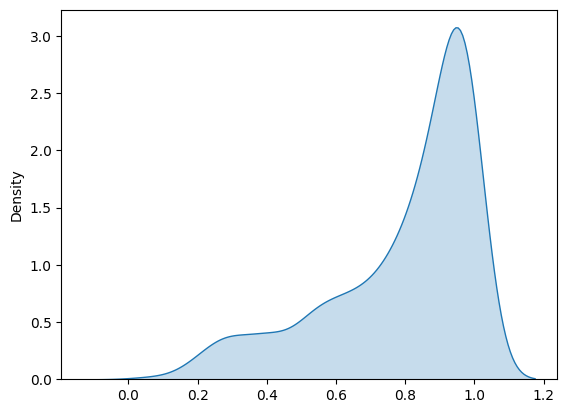

In [59]:
sns.kdeplot(trust_scores, fill = True)

In [60]:
np.mean(trust_scores)

0.7910136073400341

In [61]:
rf.oob_score_

0.7879213483146067

In [62]:
x['trust'] = trust_scores
x['oob_preds'] = np.argmax(rf.oob_decision_function_, axis = 1)
x['class'] = y
x['oob_correct'] = x['oob_preds'] == x['class'] 
x['trust_max_proba'] = rf.trust_max_proba
x['trust_minus'] = rf.trust_minus

In [63]:
x.groupby('oob_correct')['trust'].mean()

oob_correct
False    0.571119
True     0.850201
Name: trust, dtype: float64

In [91]:
x.groupby('oob_correct')['trust_max_proba'].mean()

oob_correct
False    0.459922
True     0.755271
Name: trust_max_proba, dtype: float64

<Axes: ylabel='Count'>

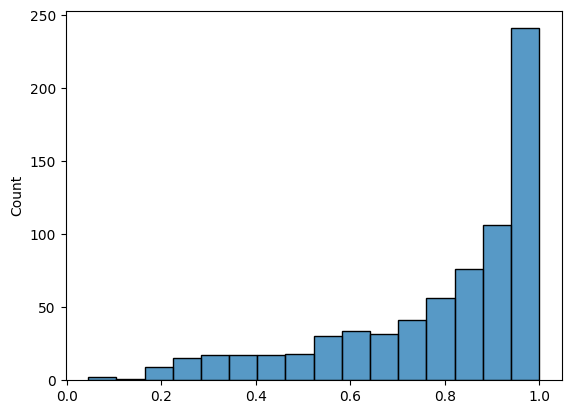

In [64]:
sns.histplot(trust_scores)

In [65]:
x['trust'] = rf.trust_correct_proba
x['class'] = y

In [66]:
# sns.pairplot(x, hue = 'class', plot_kws = {'s': 10})

In [67]:
def rescale(x):
    return 100 - (x - x.min())/(x.max() - x.min()) * 100 + 5

In [68]:
phate_op = PHATE(knn_dist = 'precomputed')
emb = phate_op.fit_transform(prox2)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 712 observations.
  Calculating graph and diffusion operator...
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 0.56 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.17 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.21 seconds.
Calculated PHATE in 0.95 seconds.


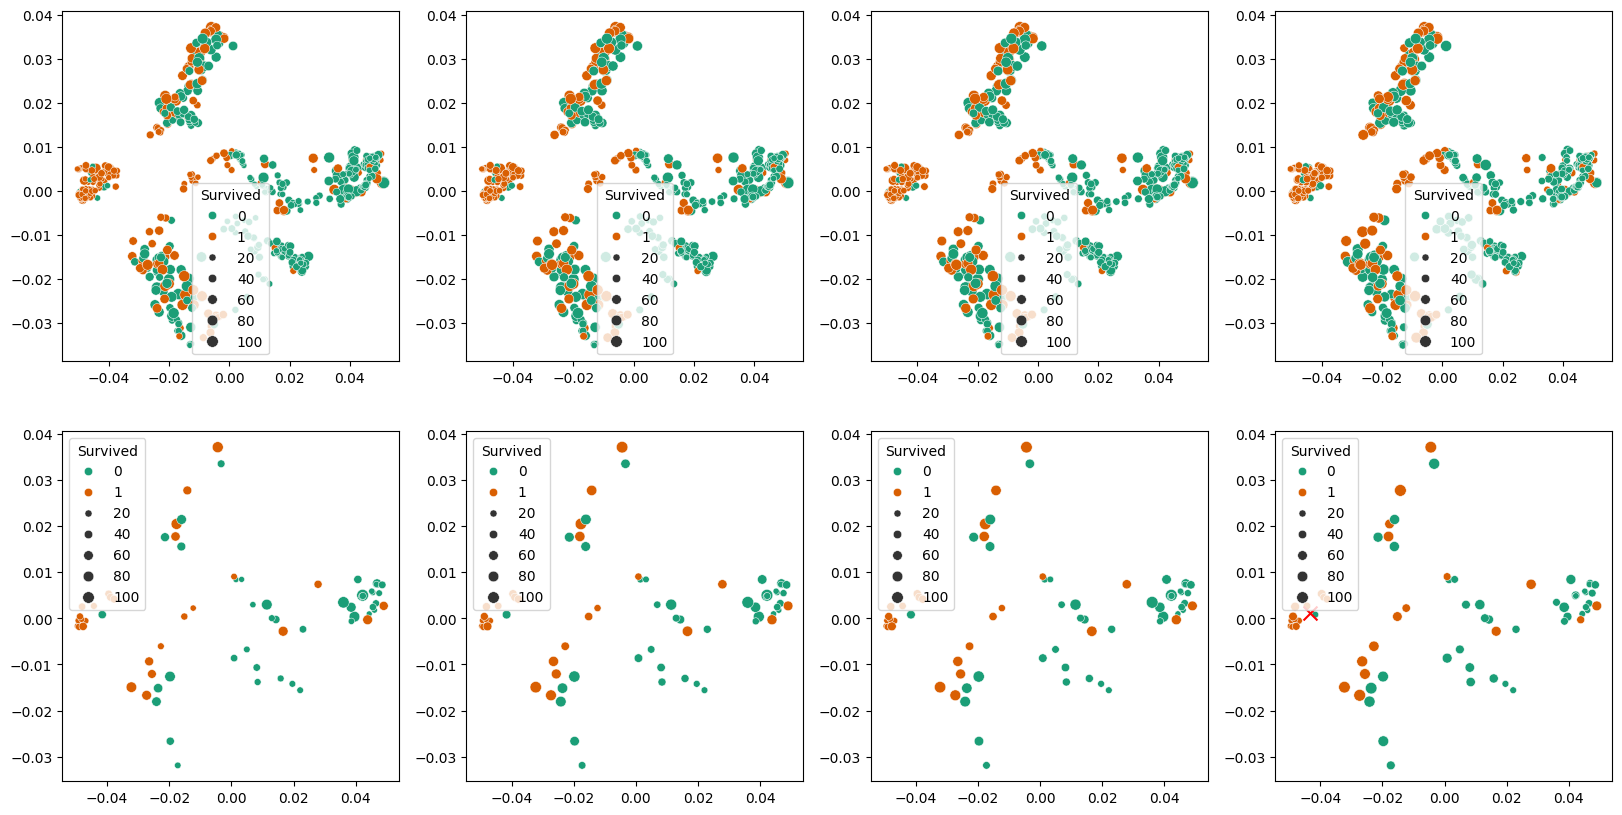

In [69]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10))

sns.scatterplot(ax = axes[0, 0], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_scores), palette = 'Dark2')
sns.scatterplot(ax = axes[0, 1], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_correct_proba), palette = 'Dark2')
sns.scatterplot(ax = axes[0, 2], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_max_proba), palette = 'Dark2') 
sns.scatterplot(ax = axes[0, 3], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_minus), palette = 'Dark2')

sns.scatterplot(ax = axes[1, 0], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_scores_test), palette = 'Dark2')
sns.scatterplot(ax = axes[1, 1], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_correct_proba_test), palette = 'Dark2')
sns.scatterplot(ax = axes[1, 2], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_max_proba_test), palette = 'Dark2') 
sns.scatterplot(ax = axes[1, 3], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_minus_test), palette = 'Dark2')

plt.scatter(emb[483, 0], emb[483, 1], s = 100, c = 'r', marker = 'x')



<Axes: >

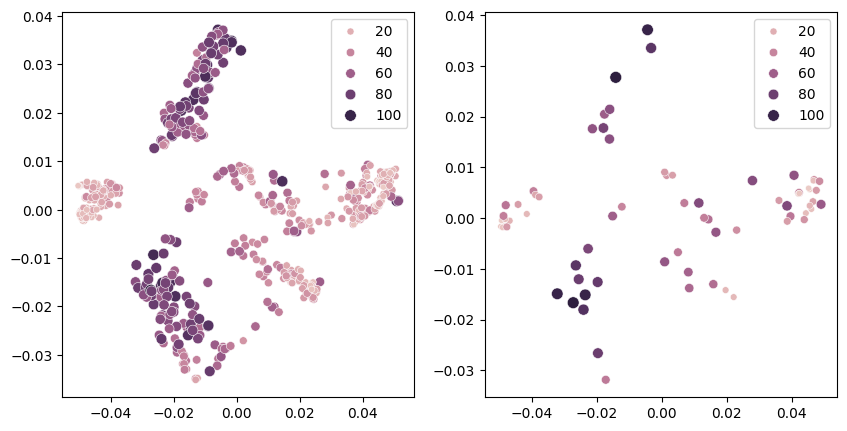

In [70]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.scatterplot(ax = axes[0], x = emb[:, 0], y = emb[:, 1], hue = rescale(rf.trust_minus), size = rescale(rf.trust_minus))
sns.scatterplot(ax = axes[1], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = rescale(rf3.trust_minus_test), size = rescale(rf3.trust_minus_test))

# plt.scatter(emb[49, 0], emb[49, 1], s = 100, c = 'r', marker = 'x')
# plt.scatter(emb[72, 0], emb[72, 1], s = 100, c = 'g', marker = 'x')

<Axes: >

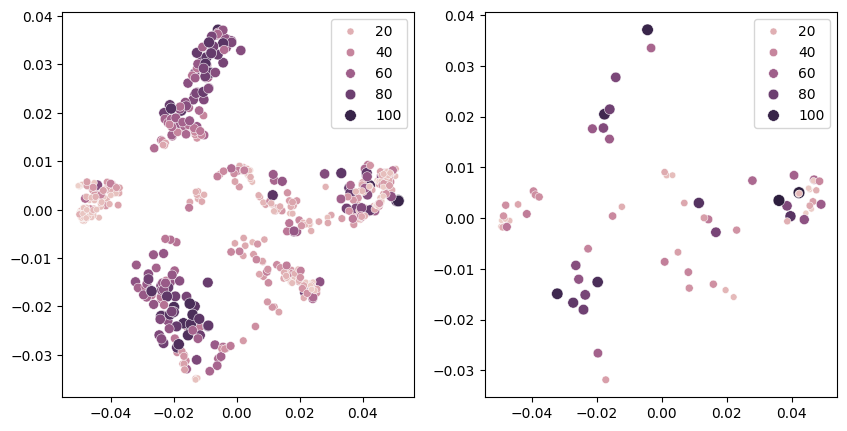

In [71]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.scatterplot(ax = axes[0], x = emb[:, 0], y = emb[:, 1], hue = rescale(rf.trust_max_proba), size = rescale(rf.trust_max_proba))
sns.scatterplot(ax = axes[1], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = rescale(rf3.trust_max_proba_test), size = rescale(rf3.trust_max_proba_test))

# plt.scatter(emb[49, 0], emb[49, 1], s = 100, c = 'r', marker = 'x')
# plt.scatter(emb[72, 0], emb[72, 1], s = 100, c = 'g', marker = 'x')

In [72]:
rf3.oob_score_

0.7890625

In [73]:
x['oob_correct'] = rf.is_correct_oob

In [74]:
x.groupby('oob_correct').mean()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,trust,oob_preds,class,trust_max_proba,trust_minus
oob_correct,,,,,,,,,,,,
False,0.635762,0.655629,0.366161,0.084768,0.049669,0.069213,0.705298,0.459922,0.476821,0.523179,0.459922,0.559465
True,0.615865,0.631016,0.367485,0.107665,0.078134,0.067002,0.822638,0.755271,0.372549,0.372549,0.755271,0.740803


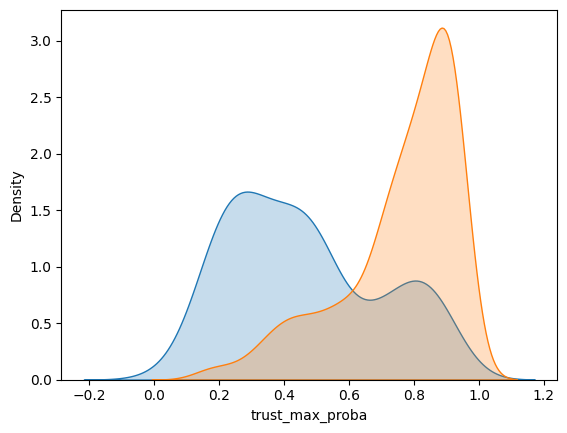

In [90]:
for group in x.groupby('oob_correct'):
    sns.kdeplot(group[1]['trust_max_proba'], fill = True)

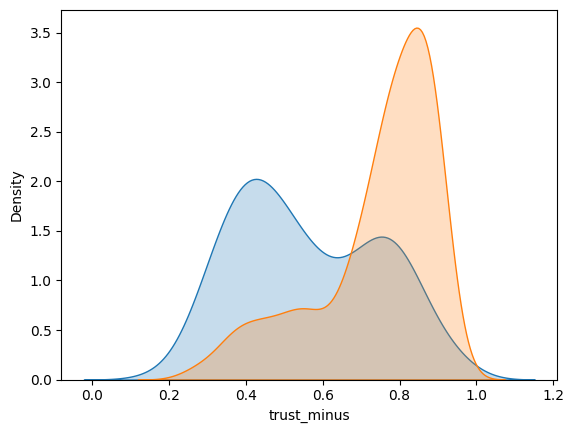

In [86]:
for group in x.groupby('oob_correct'):
    sns.kdeplot(group[1]['trust_minus'], fill = True)

<Axes: xlabel='trust_max_proba', ylabel='Density'>

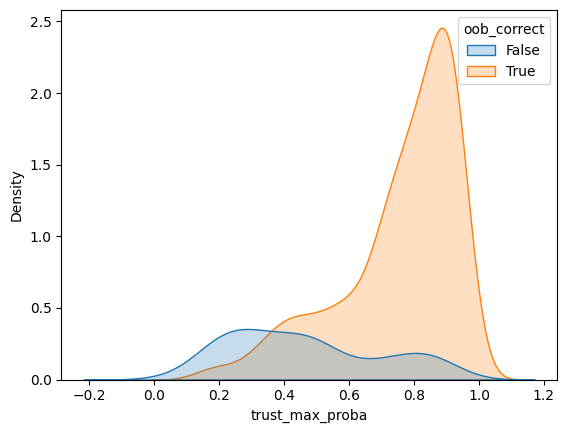

In [89]:
sns.kdeplot(data = x, hue = 'oob_correct', x = 'trust_max_proba', fill = True)

<Axes: xlabel='Pclass', ylabel='Sex'>

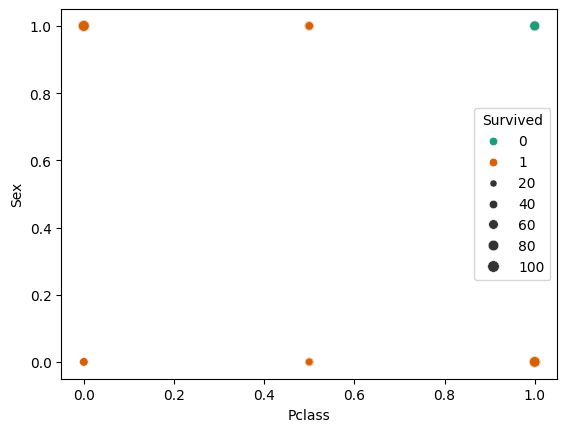

In [78]:
sns.scatterplot(x = x.iloc[inds_test, 0], y = x.iloc[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_minus_test), palette = 'Dark2')

<Axes: xlabel='Pclass', ylabel='Sex'>

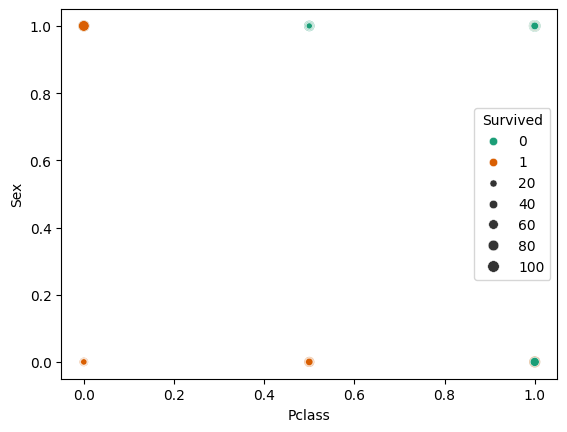

In [79]:
sns.scatterplot(x = x.iloc[:, 0], y = x.iloc[:, 1], hue = y, size = rescale(rf.trust_scores), palette = 'Dark2')

In [80]:
inds_test[np.argmin(rf3.trust_scores_test)]

49

In [81]:
inds_test[np.argmax(rf3.trust_scores_test)]

72

In [82]:
# TODO: Experiment: make bivariate blobs, but put a point in the middle of the
# opposite blob class. Then, check if the trust score is low for that point under
# a few conditions: 1) with raw trust, 2) with raw trust multiplied by max proba
# 3) with raw trust mutliplied by correct proba.

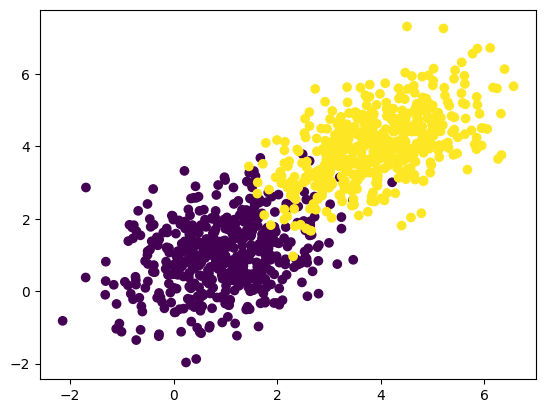

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Set the seed for reproducibility
np.random.seed(42)

# Generate data for class 1
mu1 = [1, 1]
cov1 = [[1, 0.3], [0.3, 1]]
data1 = np.random.multivariate_normal(mu1, cov1, 500)

# Generate data for class 2
mu2 = [4, 4]
cov2 = [[1, 0.6], [0.6, 1]]
data2 = np.random.multivariate_normal(mu2, cov2, 500)

# Combine the data and create labels
X = np.vstack((data1, data2))
y = np.hstack((np.zeros(500), np.ones(500)))

# Plot the data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [84]:
data = np.column_stack((y, X))

In [85]:
# np.savetxt('../datasets/2_class_normal.csv', data, delimiter = ',')